# Extra functions

In [1]:
from utils import remove_extended_hours
from datetime import datetime, date, timedelta
import mplfinance as mpf
import pandas as pd
import numpy as np
import os
import pyarrow as pa
import pyarrow.parquet as pq
DATA_PATH = "../data/polygon/"

In [2]:
def get_id(ticker, timeframe="daily"):
    """Get the most recent ID corresponding to the ticker

    Args:
        timeframe (int or str): 1 for 1-minute, 5 for 5-minute, else daily
        ticker (str): _description_

    Returns:
        string: the ID
    """
    if timeframe in [1, 5]:
        all_files = os.listdir(DATA_PATH + f'processed/m{timeframe}/')

    else:
        all_files = os.listdir(DATA_PATH + f'processed/d1/')
            
    all_IDs = [file[:-8] for file in all_files]
    IDs = [id for id in all_IDs if id[:-11] == ticker]
    return sorted(IDs)[-1]

In [3]:
def get_data(ticker_or_id, start=date(2000, 1, 1), end=date(2100, 1, 1), timeframe="daily", regular_hours_only=False, location='processed'):
    """Retrieves the data from our database

    Args:
        ticker_or_id (str): the ticker or ID
        start (datetime/date, optional): the start date(time) (inclusive). Defaults to no bounds.
        end (datetime/date, optional): the end date(time) (inclusive). Defaults to no bounds.
        timeframe (str, optional): 1 for 1-minute, 5 for 5-minute. Defaults to daily bars.
        regular_hours_only (bool, optional): Whether we need to remove extended hours. Defaults to False.
        location (str): 'processed' or 'raw'. Defaults to 'processed'.

    Returns:
        DataFrame: the output
    """

    # Determine if is ID or ticker
    if ticker_or_id[-1].isnumeric():
        id = ticker_or_id
    else:
        id = get_id(ticker_or_id, timeframe)
        
    # Read data
    if timeframe in [1, 5]:
        dataset = pq.ParquetDataset(DATA_PATH + f'{location}/m{timeframe}/{id}.parquet', filters=[("datetime", ">=", start), ("datetime", "<=", end)] )
    else:
        dataset = pq.ParquetDataset(DATA_PATH + f'{location}/d1/{id}.parquet', filters=[("datetime", ">=", start), ("datetime", "<", end + timedelta(days=1))] )
    df = dataset.read().to_pandas()
    
    # Remove extended hours if necessary
    if regular_hours_only and (timeframe in [1, 5]):
        return remove_extended_hours(df)
    else:
        return df 

In [4]:
get_id("A")

'A-2019-01-01'

In [5]:
get_data("AA", date(2020, 1, 1), date(2020, 1, 5), timeframe = 'd')

,open,high,low,close,volume,tradeable,halted
datetime,,,,,,,
2020-01-02,21.692657,21.812395,21.268582,21.378343,2.720044e+06,True,False
2020-01-03,21.203724,21.562940,21.103942,21.443201,2.696646e+06,True,False


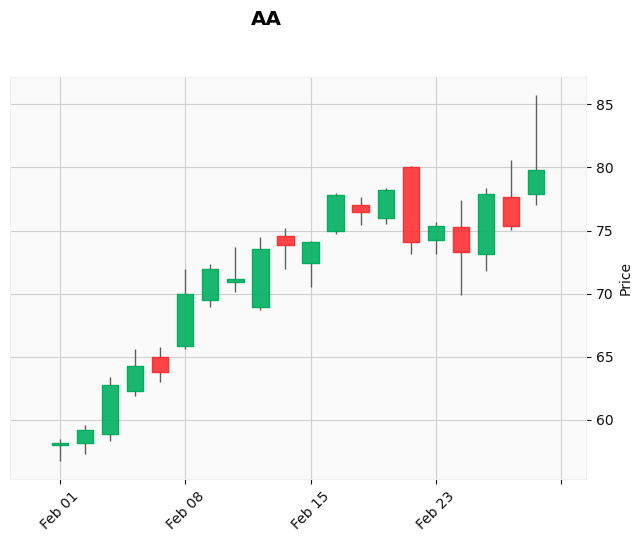

In [6]:
mpf.plot(get_data("AA", date(2022, 2, 1), date(2022, 3, 1)), type='candle', style='yahoo', title='AA')